<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
This notebook plots LCMS for Y622 +/- CDP-choline

</div>



In [1]:
import os
import urllib.request
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
os.sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano, plot_pca, count_unsaturations, count_carbons, plot_lfcs, plot_carbon_distributions, plot_class_counts, plot_with_blank, classify_fatty_acid_length, classify_unsaturation
# load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# load libraries
output_dir = "../../LCMS/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

urls = ['https://storage.googleapis.com/abca7lof/LCMS/SUB14737/5041.SUB14737_LipidXData.csv']

for url in urls:
    local_filename = os.path.join(output_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, local_filename)
    print("Download completed!")


Download completed!


In [2]:
output_dir = "../../../LCMS/"

# load data
data = pd.read_csv(local_filename)
data['score'] = -np.log10(data['p_value[s2-over-s1]']) * np.sign(data['log_ratio[s2-over-s1]'])
data.index = data['name']

# load lipid key
key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))

# sample key 
sample_dictionary = {'s1':'H2O',
                     's2':'CDP-Choline',
                     's3':'Extraction blank',
                     'c]':'Solvent blank'}


lipid_palette = {
    'Sphingolipids':'#1DC9A4',
    'Neutral lipids':'#E3120B',
    'Phospholipids':'#475ED1',
    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids':'darkblue'
}

pufa_palette = {
    'PUFA':'#333333',
    'MUFA':'#1F2E7A',
    'SFA':'#475ED1'
}

key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))


In [3]:
# annotate the classes
data['group'] = data['class'].map(dictionary)
data['class'].unique()

# get areas
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1][:2] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])
names_no_blank = areas_columns[:-1]

# subtract blank
areas_no_blank = areas.iloc[:,areas_columns!='Extraction blank']
ext_blank = areas.iloc[:, areas_columns == 'Extraction blank'].squeeze()

# remove extraction blank
areas_no_blank_H20_blank_removed = areas_no_blank.subtract(3*ext_blank, axis=0)

# set neg values to zero
areas_no_blank_H20_blank_removed_zeroed = areas_no_blank_H20_blank_removed.copy()
areas_no_blank_H20_blank_removed_zeroed[areas_no_blank_H20_blank_removed_zeroed < 0] = 0

# get significant compounds
stats = return_stats(areas_no_blank_H20_blank_removed_zeroed, names_no_blank, 'H2O', 'CDP-Choline', equal_var=True)
stats['cat'] = 'other'
stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['p_value'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]


# categorize species
stats['cat'] = 'other'
stats.loc[(stats['log2_fold_change']< -1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'down'
stats.loc[(stats['log2_fold_change']>1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'up'
stats['cat'] = stats['cat'].astype(str)

stats.head()

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.inf


,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,cat,name,grp,class,carbons,unsaturations,unsat_grp
Cer(d16:0_16:0)+H_53.21,-1.652058,0.137126,-3.152181,0.601567,other,Cer(d16:0_16:0)+H_53.21,Sphingolipids,Cer,32,0,SFA
Cer(d18:0_16:0)+H_41.29,-0.560525,0.590470,-0.695298,0.865391,other,Cer(d18:0_16:0)+H_41.29,Sphingolipids,Cer,34,0,SFA
Cer(d18:1_14:0)+H-H2O_39.3,0.487443,0.639021,0.272482,0.883141,other,Cer(d18:1_14:0)+H-H2O_39.3,Sphingolipids,Cer,32,1,MUFA
Cer(d18:1_14:0)+H_39.3,0.450326,0.664429,0.253561,0.888152,other,Cer(d18:1_14:0)+H_39.3,Sphingolipids,Cer,32,1,MUFA
Cer(d18:1_16:0)+H-H2O_40.9,-0.247099,0.811055,-0.118390,0.915227,other,Cer(d18:1_16:0)+H-H2O_40.9,Sphingolipids,Cer,34,1,MUFA


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na o

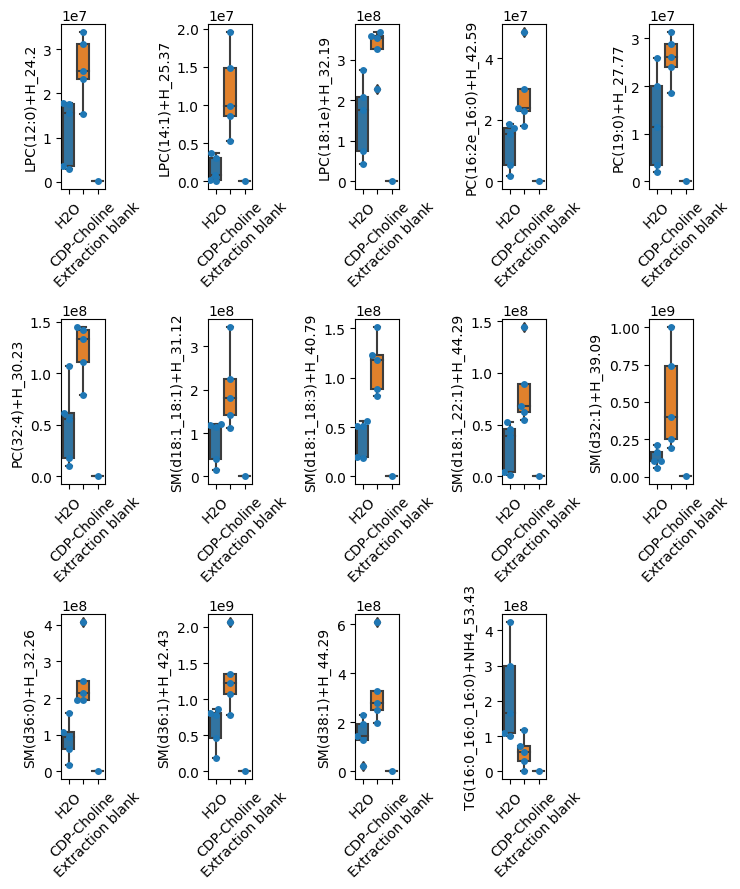

In [4]:
# show sig lipids with blanks
areas_sub = areas.loc[stats[(stats['p_value']<0.05) & (np.abs(stats['log2_fold_change'])>1)].index].iloc[:,(areas_columns=='H2O') | (areas_columns=='CDP-Choline') | (areas_columns=='Extraction blank')]
areas_sub.columns = areas_columns[(areas_columns=='H2O') | (areas_columns=='CDP-Choline') | (areas_columns=='Extraction blank')]
areas_sub = areas_sub.T
areas_sub['grp'] = areas_sub.index
plot_with_blank(areas_sub)

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


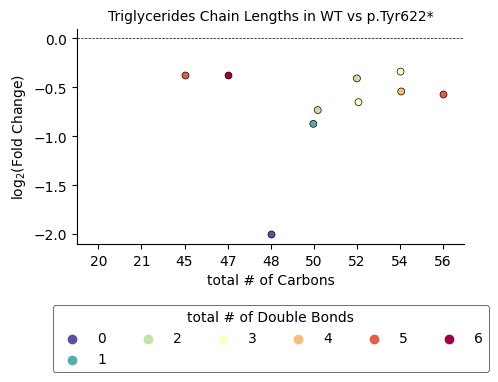

In [5]:
temp = stats[stats['class']=='TG'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='carbons', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'unsaturations', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Double Bonds')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Carbons', fontsize=10)
plt.title('Triglycerides Chain Lengths in WT vs p.Tyr622*', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('../../../paper/main_plots/tg_carbons_with_choline_batch1.png', dpi=300, bbox_inches='tight')


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


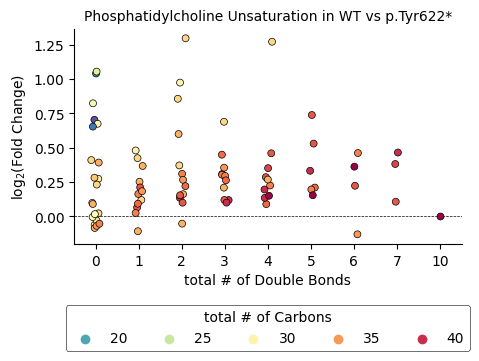

In [6]:
temp = stats[stats['class']=='PC'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='unsaturations', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'carbons', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Carbons')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Double Bonds', fontsize=10)
plt.title('Phosphatidylcholine Unsaturation in WT vs p.Tyr622*', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('../../../paper/main_plots/pc_unsat_with_choline_batch1.png', dpi=300, bbox_inches='tight')


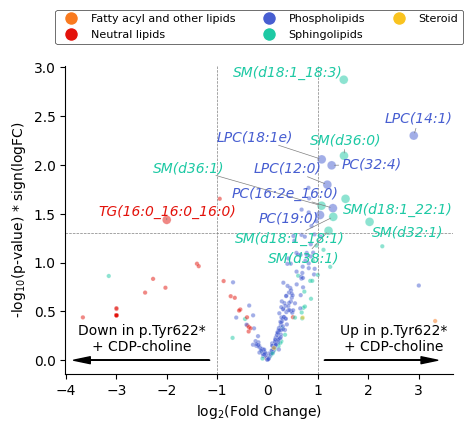

In [11]:
stats_for_volcano = stats.copy()
stats_for_volcano.loc[stats_for_volcano['log2_fold_change']==-np.inf, 'log2_fold_change'] = -3
stats_for_volcano.loc[stats_for_volcano['log2_fold_change']==np.inf, 'log2_fold_change'] = 3

plot_volcano('p_value', 'name', 'grp', 'log2_fold_change',stats_for_volcano, lipid_palette, force_text=35, max_size=40, alpha=0.5, subset_top_genes_by_lfc=True)

# plt.ylim(-0.1,4)
# plt.xlim(-3,2)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(p-value) * sign(logFC)')

plt.annotate('', xy=(3.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.1, headwidth=5))
plt.text(2.5, .1, 'Up in p.Tyr622*\n+ CDP-choline', ha='center', fontsize=10)

plt.annotate('', xy=(-4,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.1, headwidth=5))
plt.text(-2.5, .1, 'Down in p.Tyr622*\n+ CDP-choline', ha='center', fontsize=10)


labels = np.unique(stats_for_volcano['grp'])[[x!='Neutral glycerolipid' for x in np.unique(stats_for_volcano['grp'])]]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=lipid_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=8)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)


plt.savefig('../../../paper/main_plots/all_lipids_choline_batch1.png', dpi=300, bbox_inches='tight')



### Additional plots

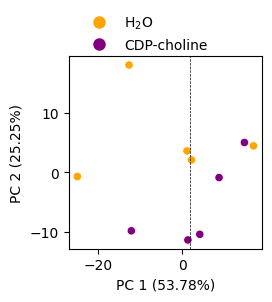

In [8]:
plot_pca(selected_rows, names_sele, palette={'H2O':'orange', 'CDP-Choline' : 'purple'}, draw_median=True)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
        markerfacecolor='orange', markersize=10,linestyle='None', label='H$_2$O'),
    Line2D([0], [0], marker='o', markerfacecolor='purple',color='w',
        markersize=10, linestyle='None', label='CDP-choline')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(df['class'][0], rotation=0, ha='right', va='center')
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(df['class'][0], rotation=0, ha='right', va='center')
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

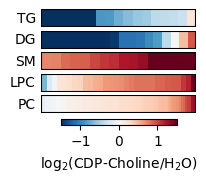

In [9]:
stats['class'] = [x.split('(')[0] for x in stats.index]
heatmap_data_list = [
    stats[stats['class'] == 'TG'],
    stats[stats['class'] == 'DG'],
    stats[stats['class'] == 'SM'],
    stats[stats['class'] == 'LPC'],
    stats[stats['class'] == 'PC']
]
cbar = plot_lfcs(heatmap_data_list, 'log2_fold_change')
cbar.set_label('log$_{2}$(CDP-Choline/H$_{2}$O)')

In [10]:
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)


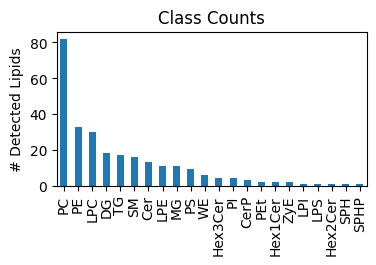

In [11]:
plt.figure(figsize=(4,2))
plot_class_counts(stats)

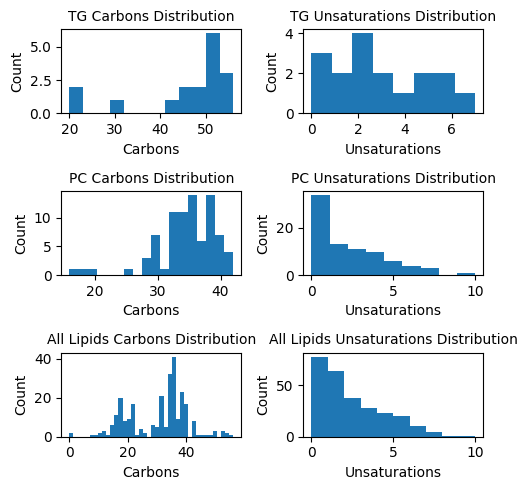

In [12]:
plot_carbon_distributions(stats)

In [9]:
# by group stats
groups = [x.split('(')[0] for x in selected_rows.index]
by_grp = selected_rows.groupby(groups).sum()
by_grp_stats = return_stats(by_grp, names_sele,  'H2O', 'CDP-Choline', equal_var=True)

by_grp_stats['score'] = -1*np.log10(by_grp_stats['p_value']) * np.sign(by_grp_stats['log2_fold_change'])
by_grp_stats.sort_values(by='p_value')

,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,score
MG,-2.757958,0.024753,-2.535170,0.389386,-1.606377
TG,-2.260789,0.053656,-1.071939,0.389386,-1.270380
DG,-2.183927,0.060491,-2.392496,0.389386,-1.218309
LPS,1.975425,0.083639,0.776679,0.389386,1.077593
SM,1.813605,0.107297,0.969671,0.389386,0.969411
LPC,1.736870,0.120617,0.552179,0.389386,0.918592
WE,-1.719202,0.123896,-1.340315,0.389386,-0.906944
LPI,1.519738,0.167064,0.576888,0.459425,0.777118
PEt,1.230940,0.253305,0.302344,0.532682,0.596356
PS,1.208550,0.261343,0.428616,0.532682,0.582790


In [10]:
# classify fatty acids in TGs
selected_rows_TG = selected_rows[np.array(groups)=='TG']

carbon_counts_classified = np.array([classify_fatty_acid_length(count_carbons(x)/3) for x in selected_rows_TG.index])

by_grp = selected_rows_TG.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, names_sele,  'H2O', 'CDP-Choline')
by_grp_stats



/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: invalid value encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.nan


,t_stat,p_value,log2_fold_change,fdr_corrected_p_value
LCFA,-1.595450,0.155827,-0.727797,0.155827
MCFA,-2.106687,0.086046,NaN,0.155827


In [11]:
# classify fatty acids in PCs
selected_rows_PC = selected_rows[np.array(groups)=='PC']

carbon_counts_classified = np.array([classify_unsaturation(count_unsaturations(x)) for x in selected_rows_PC.index])

by_grp = selected_rows_PC.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, names_sele,  'H2O', 'CDP-Choline')
by_grp_stats



,t_stat,p_value,log2_fold_change,fdr_corrected_p_value
MFA,0.936319,0.391122,0.268417,0.391122
PUFA,0.988075,0.364674,0.284419,0.391122
UFA,0.984925,0.363785,0.215329,0.391122


In [ ]:
# # Example: list of dataframes for each heatmap (replace with your actual dataframes)


# def plot_lfcs(heatmap_data_list, stats, lfc_column):
#     # Number of heatmaps
#     n_heatmaps = len(heatmap_data_list)

#     # Create a figure with n_heatmaps rows and 1 column
#     fig, axes = plt.subplots(nrows=n_heatmaps, ncols=1, figsize=(2, n_heatmaps * .3))

#     # If there's only one heatmap, ensure axes is iterable
#     if n_heatmaps == 1:
#         axes = [axes]

#     # Loop over each dataframe and axis
#     for ax, df in zip(axes, heatmap_data_list):
#         # Sort the data by the column of interest
#         sorted_data = stats[[lfc_column]].sort_values(by=lfc_column)
#         # Transpose so the heatmap is horizontal (one row rather than one column)
#         sorted_data = sorted_data.T
        
#         # Plot the horizontal heatmap on the given axis
#         im = sns.heatmap(sorted_data, annot=False, cmap='RdBu_r', vmin=-1.5, vmax=1.5,
#                     cbar_kws={'label': lfc_column}, ax=ax, cbar=False)
        
#         # Set a title for the heatmap (displayed above each plot)
#         ax.set_title('')
#         ax.set_ylabel('')
#         ax.set_xlabel('')
#         # Optionally remove x-axis tick labels if they correspond to species names or similar unwanted labels
#         ax.set_xticklabels([])
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_ylabel(df['class'][0], rotation=0, ha='right', va='center')
        
#         rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes,
#                         fill=False, color="black", linewidth=1.5)
#         ax.add_patch(rect)
#         if df['class'][0] == 'MG':
#             ax.set_title('Neutral lipids', fontsize=10)
#         # if df['class'][0] == 'SM':
#         #     ax.set_title('Phospholipids', fontsize=10)
        
#     plt.subplots_adjust(hspace=0.1)

#     if n_heatmaps >= 4:
#         # Get the current position of the 4th subplot
#         pos = axes[3].get_position()
#         # Increase the vertical gap by shifting the 4th subplot downward.
#         # For example, subtracting an extra 0.4 from the y0 position.
#         new_pos = [pos.x0, pos.y0 - 0.4, pos.width, pos.height]
#         axes[3].set_position(new_pos)

#         axes[3].text(.5, 3.5, 'Phospholipids',fontsize=10,
#                     transform=axes[3].transAxes, ha='center', va='bottom')
            
#         #axes[3].title.set_position([1.5,0])
#     #axes[3].set_title(titles[3], pad=20)
        
#         # Option 2: Alternatively, directly set the title's y-coordinate
#         #axes[3].title.set_y(2)

#     cbar = fig.colorbar(im.collections[0], ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
#     cbar.set_label('log$_{2}$(CDP-Choline/H$_{2}$O)')



